In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical


### Data Loading ###

In [2]:
# Random crop and scale, horizantal & vertical flip, rotation has already been done

# read images
silver_train_df = pd.read_csv('Gardner_train_silver.csv', sep=';')
gold_test_df = pd.read_csv('Gardner_test_gold.csv', sep=';')
# Drop the unnecessary column
gold_test_df.drop(columns=['Unnamed: 4'], inplace=True)
image_dir = 'Images'

# Ensure labels are one-hot encoded in the DataFrame
silver_train_df['EXP_silver'] = silver_train_df['EXP_silver'].apply(lambda x: to_categorical(x, num_classes=5))
silver_train_df['ICM_silver'] = silver_train_df['ICM_silver'].apply(lambda x: to_categorical(x, num_classes=4))
silver_train_df['TE_silver'] = silver_train_df['TE_silver'].apply(lambda x: to_categorical(x, num_classes=4))

silver_train_df

,Image,EXP_silver,ICM_silver,TE_silver
0,0175_05.png,"[0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 1.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0]"
1,420_02.png,"[0.0, 0.0, 0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]"
2,680_01.png,"[0.0, 0.0, 1.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]"
3,340_03.png,"[0.0, 0.0, 0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0]"
4,571_02.png,"[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 1.0]"
...,...,...,...,...
2039,540_01.png,"[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 1.0]"
2040,707_01.png,"[0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 1.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]"
2041,366_01.png,"[0.0, 0.0, 0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]"
2042,0071_02.png,"[0.0, 0.0, 1.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0]"


In [3]:
# Replace 'ND' with 3
gold_test_df.replace('ND', 3, inplace=True)

# Replace NaN with -1
gold_test_df.fillna(-1, inplace=True)
# Convert 'EXP_gold' column to integer type
gold_test_df['EXP_gold'] = gold_test_df['EXP_gold'].astype(int)
gold_test_df['ICM_gold'] = gold_test_df['ICM_gold'].astype(int)
gold_test_df['TE_gold'] = gold_test_df['TE_gold'].astype(int)

gold_test_df

,Image,EXP_gold,ICM_gold,TE_gold
0,0004_03.png,2,1,1
1,0005_08.png,3,0,0
2,0008_01.png,2,0,0
3,0011_02.png,0,3,3
4,0011_03.png,3,1,0
...,...,...,...,...
295,833_02.png,-1,-1,1
296,835_05.png,3,0,-1
297,836_01.png,3,2,1
298,837_01.png,3,0,1


(384, 512, 3)
uint8


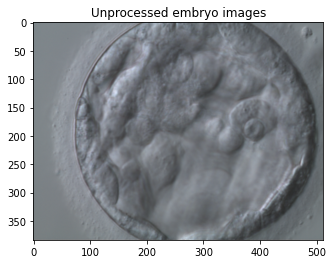

In [6]:
# load images
train_images_path = [image_dir + '/' + i for i in silver_train_df['Image']]
test_images_path = [image_dir + '/' + i for i in gold_test_df['Image']]

#read original (unprocessed) images
train_img = cv2.imread(train_images_path[0])
print(train_img.shape)
print(train_img.dtype)
plt.title("Unprocessed embryo images")
plt.imshow(train_img)

### Model Deployment 

In [ ]:


# define input size
input_size = (224,224,3)

# socre categories for each grading criteria
num_classes_exp = 5 
num_classes_icm = 4
num_class_te = 4

# Load the ResNet50 model for feature extraction
base_model = ResNet50(
    input_shape=input_size, 
    include_top=False, 
    weights='imagenet') # load  pre-trained model with ImageNet weights
    # pooling layer is yet to be determined
base_model.trainable=False

# flatten the output of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x) # pool the feature from base CNN

# add a Dense layer for each grading criteria
output_exp = layers.Dense(num_classes_exp, activation='softmax', name='output_exp')(x)
output_icm = layers.Dense(num_classes_icm, activation='softmax', name='output_icm')(x)
output_te = layers.Dense(num_class_te, activation='softmax', name='output_te')(x)

# create a multi-output model
model = Model(inputs=base_model.input, outputs=[output_exp, output_icm, output_te])

# compile the model
model.compile(optimizer= 'adam',
              loss={'output_exp': 'categorical_crossentropy',
                    'output_icm': 'categorical_crossentropy',
                    'output_te': 'categorical_crossentropy'},
              metrics= ['accuracy'])

# check the model summary
model.summary()


In [10]:
# data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from tensorflow.keras.optimizers import Adam
import numpy as np
import math

# Hyperparameters from the paper
initial_lr = 5e-04
swa_lr = 2.5e-04
warmup_lr = 1e-06
epochs = 60
warmup_epochs = 5
batch_size = 64
swa_start_epoch = 30

# Function for learning rate scheduler with warmup
def lr_schedule(epoch):
    if epoch < warmup_epochs:
        return warmup_lr + (initial_lr - warmup_lr) * (epoch / warmup_epochs)
    else:
        return initial_lr * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))



# training & validataion set are 80-20 split
datagen = ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function=preprocess_input,
    validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    dataframe = silver_train_df,
    directory = 'Images',
    x_col = 'Image',
    y_col = (['EXP_silver', 'ICM_silver', 'TE_silver']),
    target_size = (224,224),
    batch_size = 64, # same as "Annotaed paper" settings
    class_mode = 'multi_output',
    subset = 'training')

val_gen = datagen.flow_from_dataframe(
    dataframe = silver_train_df,
    directory = 'Images',
    x_col = 'Image',
    y_col = (['EXP_silver', 'ICM_silver', 'TE_silver']),
    target_size = (224,224),
    batch_size = 64, # same as "Annotaed paper" settings
    class_mode = 'multi_output',
    subset = 'validation')

# Custom callback for Stochastic Weight Averaging (SWA)
class SWACallback(Callback):
    def __init__(self, start_epoch, swa_lr, model):
        super(SWACallback, self).__init__()
        self.start_epoch = start_epoch
        self.swa_lr = swa_lr
        self.swa_weights = None
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        if epoch >= self.start_epoch:
            # Switch to SWA learning rate
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.swa_lr)
            # Update the SWA weights
            if self.swa_weights is None:
                self.swa_weights = [np.array(weight) for weight in self.model.get_weights()]
            else:
                for i, weight in enumerate(self.model.get_weights()):
                    self.swa_weights[i] += np.array(weight)
            
            # Average the SWA weights
            num_updates = epoch - self.start_epoch + 1
            self.swa_weights = [weight / num_updates for weight in self.swa_weights]

    def on_train_end(self, logs=None):
        # Set the final weights to the averaged SWA weights
        if self.swa_weights is not None:
            self.model.set_weights(self.swa_weights)


# Set the callbacks: Learning rate scheduler and SWA
callbacks = [
    LearningRateScheduler(lr_schedule),  # Learning rate scheduler with warmup and cosine decay
    SWACallback(start_epoch=swa_start_epoch, swa_lr=swa_lr, model=model)  # Custom SWA callback
]


#train the model using the data generator
history = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = epochs,
    callbacks = callbacks)    


Found 1636 validated image filenames.
Found 408 validated image filenames.
Epoch 1/60


2024-10-23 15:14:41.208611: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


26/26 [==============================] - 77s 3s/step - loss: 4.4429 - output_exp_loss: 1.8127 - output_icm_loss: 1.4882 - output_te_loss: 1.1420 - output_exp_accuracy: 0.0941 - output_icm_accuracy: 0.6320 - output_te_accuracy: 0.5244 - val_loss: 4.3650 - val_output_exp_loss: 1.7852 - val_output_icm_loss: 1.4519 - val_output_te_loss: 1.1278 - val_output_exp_accuracy: 0.0980 - val_output_icm_accuracy: 0.6642 - val_output_te_accuracy: 0.5466 - lr: 1.0000e-06
Epoch 2/60
26/26 [==============================] - 66s 3s/step - loss: 4.0649 - output_exp_loss: 1.6221 - output_icm_loss: 1.3347 - output_te_loss: 1.1081 - output_exp_accuracy: 0.2836 - output_icm_accuracy: 0.6320 - output_te_accuracy: 0.5244 - val_loss: 3.6951 - val_output_exp_loss: 1.4540 - val_output_icm_loss: 1.1692 - val_output_te_loss: 1.0718 - val_output_exp_accuracy: 0.5417 - val_output_icm_accuracy: 0.6642 - val_output_te_accuracy: 0.5466 - lr: 1.0080e-04
Epoch 3/60
26/26 [==============================] - 65s 2s/step - los

In [11]:
# Print the keys in the history.history dictionary
print(history.history.keys())

dict_keys(['loss', 'output_exp_loss', 'output_icm_loss', 'output_te_loss', 'output_exp_accuracy', 'output_icm_accuracy', 'output_te_accuracy', 'val_loss', 'val_output_exp_loss', 'val_output_icm_loss', 'val_output_te_loss', 'val_output_exp_accuracy', 'val_output_icm_accuracy', 'val_output_te_accuracy', 'lr'])


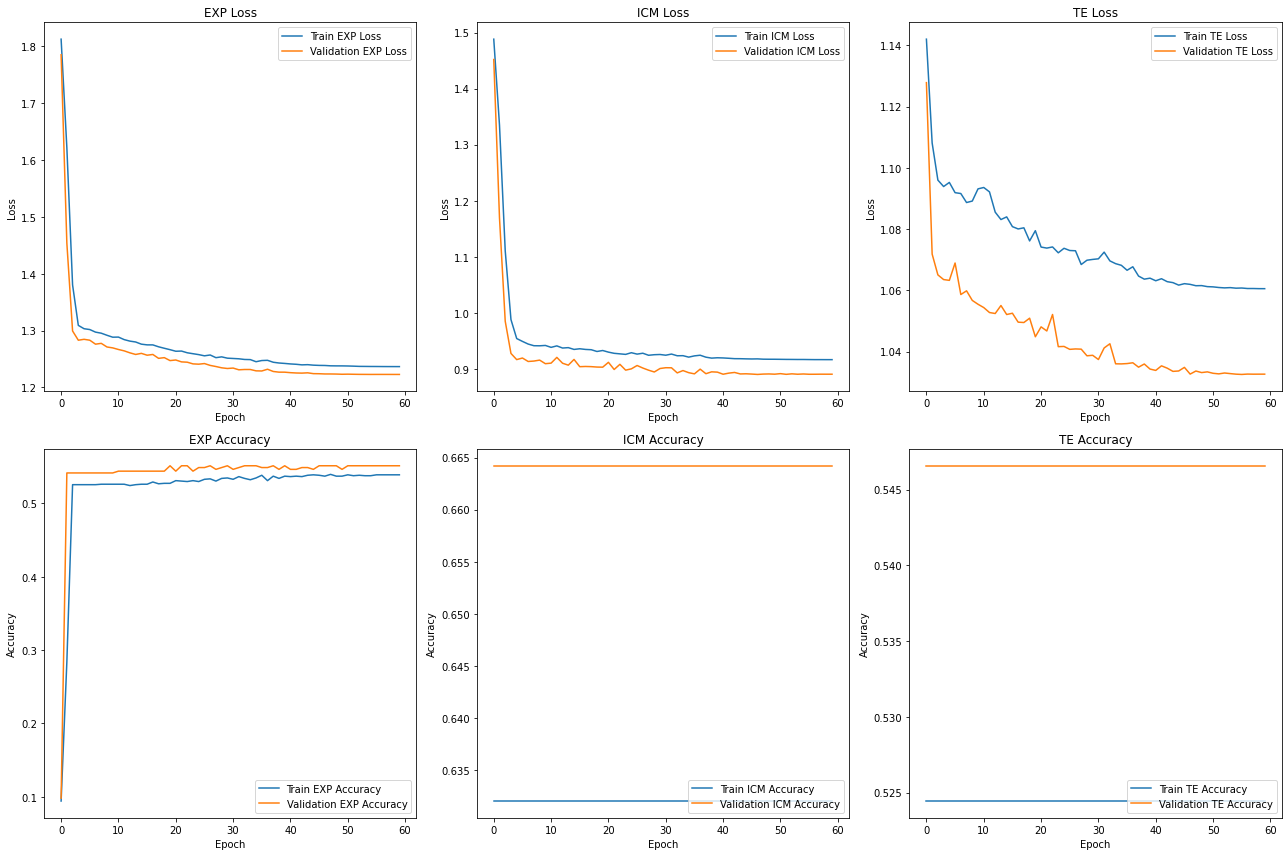

In [17]:
# Extract metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract loss and accuracy for each output
train_exp_loss = history.history['output_exp_loss']
val_exp_loss = history.history['val_output_exp_loss']
train_icm_loss = history.history['output_icm_loss']
val_icm_loss = history.history['val_output_icm_loss']
train_te_loss = history.history['output_te_loss']
val_te_loss = history.history['val_output_te_loss']

train_exp_accuracy = history.history['output_exp_accuracy']
val_exp_accuracy = history.history['val_output_exp_accuracy']
train_icm_accuracy = history.history['output_icm_accuracy']
val_icm_accuracy = history.history['val_output_icm_accuracy']
train_te_accuracy = history.history['output_te_accuracy']
val_te_accuracy = history.history['val_output_te_accuracy']

# Plot training & validation loss values
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(train_exp_loss, label='Train EXP Loss')
plt.plot(val_exp_loss, label='Validation EXP Loss')
plt.title('EXP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(2, 3, 2)
plt.plot(train_icm_loss, label='Train ICM Loss')
plt.plot(val_icm_loss, label='Validation ICM Loss')
plt.title('ICM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(2, 3, 3)
plt.plot(train_te_loss, label='Train TE Loss')
plt.plot(val_te_loss, label='Validation TE Loss')
plt.title('TE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(2, 3, 4)
plt.plot(train_exp_accuracy, label='Train EXP Accuracy')
plt.plot(val_exp_accuracy, label='Validation EXP Accuracy')
plt.title('EXP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 3, 5)
plt.plot(train_icm_accuracy, label='Train ICM Accuracy')
plt.plot(val_icm_accuracy, label='Validation ICM Accuracy')
plt.title('ICM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 3, 6)
plt.plot(train_te_accuracy, label='Train TE Accuracy')
plt.plot(val_te_accuracy, label='Validation TE Accuracy')
plt.title('TE Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Model Predication ###

In [18]:
predict_df = gold_test_df.copy()

# Remove all attribute values except first column but keep all column names
predict_df.iloc[:, 1:] = np.nan

predict_df


,Image,EXP_gold,ICM_gold,TE_gold
0,0004_03.png,NaN,NaN,NaN
1,0005_08.png,NaN,NaN,NaN
2,0008_01.png,NaN,NaN,NaN
3,0011_02.png,NaN,NaN,NaN
4,0011_03.png,NaN,NaN,NaN
...,...,...,...,...
295,833_02.png,NaN,NaN,NaN
296,835_05.png,NaN,NaN,NaN
297,836_01.png,NaN,NaN,NaN
298,837_01.png,NaN,NaN,NaN


In [19]:
# Create a data generator for the test data
test_datagen = ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function=preprocess_input)

# Evaluate the model on the test set
test_gen = test_datagen.flow_from_dataframe(
    dataframe = predict_df,
    directory = 'test',
    x_col = 'Image',
    y_col = ['EXP_gold', 'ICM_gold', 'TE_gold'],
    target_size = (224,224),
    batch_size = 64,
    class_mode = 'multi_output',
    shuffle = False)

# Make predictions on the test data
predictions = model.predict(test_gen)

# Assuming predictions is a list of arrays for each output
exp_predictions = predictions[0]
icm_predictions = predictions[1]
te_predictions = predictions[2]

# Convert predictions to class labels
exp_pred_labels = np.argmax(exp_predictions, axis=1)
icm_pred_labels = np.argmax(icm_predictions, axis=1)
te_pred_labels = np.argmax(te_predictions, axis=1)

# Combine predictions into a DataFrame
pred_df = pd.DataFrame({
    'Image': test_gen.filenames,
    'EXP_Pred': exp_pred_labels,
    'ICM_Pred': icm_pred_labels,
    'TE_Pred': te_pred_labels
})

# Display the predictions
print(pred_df.head())

Found 300 validated image filenames.


5/5 [==============================] - 10s 2s/step
         Image  EXP_Pred  ICM_Pred  TE_Pred
0  0004_03.png         4         3        1
1  0005_08.png         4         3        1
2  0008_01.png         4         3        1
3  0011_02.png         4         3        1
4  0011_03.png         4         3        1


In [20]:
gold_test_df.head()
#pred_df.to_csv('predictions.csv', index=False)

,Image,EXP_gold,ICM_gold,TE_gold
0,0004_03.png,2,1,1
1,0005_08.png,3,0,0
2,0008_01.png,2,0,0
3,0011_02.png,0,3,3
4,0011_03.png,3,1,0


In [21]:
from sklearn.metrics import f1_score

# Assuming gold_test_df contains the ground truth labels
# and pred_df contains the predicted labels

# Extract ground truth labels
exp_true_labels = gold_test_df['EXP_gold'].values
icm_true_labels = gold_test_df['ICM_gold'].values
te_true_labels = gold_test_df['TE_gold'].values

# Extract predicted labels
exp_pred_labels = pred_df['EXP_Pred'].values
icm_pred_labels = pred_df['ICM_Pred'].values
te_pred_labels = pred_df['TE_Pred'].values

# Calculate F1 scores for each category
exp_f1 = f1_score(exp_true_labels, exp_pred_labels, average='weighted')
icm_f1 = f1_score(icm_true_labels, icm_pred_labels, average='weighted')
te_f1 = f1_score(te_true_labels, te_pred_labels, average='weighted')

print(f"EXP F1 Score: {exp_f1}")
print(f"ICM F1 Score: {icm_f1}")
print(f"TE F1 Score: {te_f1}")


EXP F1 Score: 0.000546448087431694
ICM F1 Score: 0.054915254237288144
TE F1 Score: 0.11734729493891796


In [22]:
# Save the model to a specified file path
model.save('resnet50_paper.h5')